In [2]:
import numpy as np
import pandas as pd
from skimage.data import imread
import matplotlib.pyplot as plt

In [3]:
import os
print(os.listdir("../input"))

['test_v2', 'train_v2', '.ipynb_checkpoints', 'train_ship_segmentations_v2.csv']


In [4]:
train_v2 = os.listdir('../input/train_v2')
print(len(train_v2))

test_v2 = os.listdir('../input/test_v2')
print(len(test_v2))

192557
15606


# Encoding f(x)

In [5]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [12]:
masks = pd.read_csv('../input/train_ship_segmentations_v2.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [13]:
type(masks['EncodedPixels'][3])

str

In [14]:
train = masks
train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [15]:
train['exist_ship'] = train['EncodedPixels'].fillna(0)
train.loc[train['exist_ship']!=0, 'exist_ship']=1
del train['EncodedPixels']

In [16]:
train.head()

,ImageId,exist_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,000194a2d.jpg,1


In [17]:
print(len(train['ImageId']))
print(train['ImageId'].value_counts().shape[0])
train_gp = train.groupby('ImageId').sum().reset_index()
train_gp.loc[train_gp['exist_ship']>0,'exist_ship']=1

231723
192556


In [18]:
len(train_gp)

192556

In [19]:
train_gp.head()

,ImageId,exist_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0


In [20]:
print(train_gp['exist_ship'].value_counts())
train_gp= train_gp.sort_values(by='exist_ship')
train_gp = train_gp.drop(train_gp.index[0:100000])

0    150000
1     42556
Name: exist_ship, dtype: int64


In [21]:
print(train_gp['exist_ship'].value_counts())

0    50000
1    42556
Name: exist_ship, dtype: int64


# Sample

In [22]:
train_sample = train_gp.sample(1000)
print(train_sample['exist_ship'].value_counts())
print (train_sample.shape)

0    546
1    454
Name: exist_ship, dtype: int64
(1000, 2)


In [23]:
train_sample.head()

,ImageId,exist_ship
57631,4cd388767.jpg,0
62649,5370ebb1e.jpg,1
44217,3af77456c.jpg,1
4583,06200b850.jpg,0
49748,42385b882.jpg,1


* Train_path = '../input/train_v2/'
* Test_path = '../input/test_v2/'

# Resize Image

In [24]:
from PIL import Image
data = np.empty((len(train_sample['ImageId']),256,256,3), dtype=np.float32)
data_target = np.empty((len(train_sample['ImageId'])), dtype=np.int32)
image_name_list = train_v2
index = 0
for image_name in image_name_list:
    if image_name in list(train_sample['ImageId']):
        imageA = Image.open('../input/train_v2/' + image_name).resize((256,256)).convert('RGB')
        data[index]=imageA
        data_target[index]=train_sample[train_gp['ImageId'].str.contains(image_name)]['exist_ship'].iloc[0]
        index+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [25]:
print(data.shape)
print(data_target.shape)

(1000, 256, 256, 3)
(1000,)


In [26]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data,data_target, test_size = 0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((800, 256, 256, 3), (200, 256, 256, 3), (800,), (200,))

In [27]:
import tensorflow as tf
'''
x - according to the documentation I am passing a dictionary of my training features
y - passing the training labels
batch_size - how many images I want to pass to my NN in a single training step. 
             The gradients and the loss for the training step will be calculated only on these images. 
num_epochs - when I want to complete the execution of this method. With the current setting (1) 
             when the input function goes through all images once it will complete.
shuffle    - do I want to read the images in order or no. It is a better strategy to 
             shuffle within the training images during training.
'''
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={'x':x_train},
      y=y_train,
      batch_size=20,
      num_epochs=2,
      shuffle=True)

'''
What the eval_input_fn will do with its current settings is to read the entire training dataset 
(in order) using batch_size of 128 (default setting). 

Keep in mind that it will also terminate when completes 1 epoch.
'''
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':x_val},
    y=y_val,
    shuffle=False,
    num_epochs=2)



NameError: name 'test_data' is not defined

In [ ]:
# test_data.shape

In [ ]:
# test_data[400:].shape

In [28]:
def cnn_model_function(features, labels, mode):
    '''
    This is the function which describes the structure of the neural network
    '''
    
    # input layer
    # reshaping x to 4-D tensor: [batch_size, width, height, channels]
    # features['x'] - the dictionary we passed for x in the input functions
    layer_1 = tf.reshape(features['x'], [-1, 256, 256, 3])
    
    # convolution layer 1
    # computes 32 features using 10x10 filter with ReLU activation.
    # input tensor: [batch_size, 256, 256, 3]
    # output tensor: [batch_size, 256, 256, 32]
    layer_2 = tf.layers.conv2d(                          
                inputs=layer_1,
                filters=10,
                kernel_size=[10, 10],
                padding="same",
                activation=tf.nn.relu)
    
    # convolution layer 2
    # computes 32 features using 5x5 filter with ReLU activation.
    # input tensor: [batch_size, 256, 256, 32]
    # output tensor: [batch_size, 256, 256, 64]
    layer_3 = tf.layers.conv2d(
                inputs=layer_2,
                filters=20,
                kernel_size=[5, 5],
                padding="same",
                activation=tf.nn.relu)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 256, 256, 64]
    # Output Tensor Shape: [batch_size, 256 * 256 * 64]
    layer_4 = tf.reshape(layer_3, [-1, 256 * 256 * 20])
    
    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 256 * 256 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    layer_5 = tf.layers.dense(inputs=layer_4, units=20, activation=tf.nn.relu)
    
    # Dropout operation; 0.6 probability that element will be kept
    # notice that this layer will perform droupout only during training!
    layer_6 = tf.layers.dropout(inputs=layer_5, rate=0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=layer_6, units=2)
    
    # define the values which our neural network will output
    # classes - which number the NN 'thinks' is on the image
    # probabilities - how certain our NN is about its prediction
    predictions = {
                "classes": tf.argmax(input=logits, axis=1),
                "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # here we define what happens if we call the predict method of our estimator
    # with the current settings it will return the dictionary defined above
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # here we define the loss for our training (the thing we minimize)
    # I do not need to perform one-hot-encoding to my training labels because the method
    # sparse_softmax_cross_entropy will do that for me and I don't need to think about that
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # here we define how we calculate our accuracy
    # if you want to monitor your training accuracy you need these two lines
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions['classes'], name='acc_op')
    tf.summary.scalar('accuracy', accuracy[1])
    
    # here we define what happens if we call the train method of our estimator
    # with its current settings it will adjust the weights and biases of our neurons
    # using the Adam Optimization Algorithm based on the loss function we defined earlier
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        tf.identity(accuracy[1], name='train_accuracy')
        tf.summary.scalar('train_accuracy', accuracy[1])
        eval_metric_ops = {"train_accuracy":accuracy}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, eval_metric_ops=eval_metric_ops)
    
    # what evaluation metric we want to show
    tf.identity(accuracy[1], name='val_accuracy')
    tf.summary.scalar('val_accuracy', accuracy[1])
    eval_metric_ops = {'val_accuracy':accuracy}
    # here we define what happens if we call the evaluate method of our estimator
    # with its current settings it will display the loss and the accuracy which we defined earlier
    return tf.estimator.EstimatorSpec(
                mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [29]:
tf.logging.set_verbosity(tf.logging.INFO)

In [30]:
# first we define a folder where tensorflow will keep its progress
# this includes periodical saves of our weight, biases, accuracy, loss and etc.
# so if we have more training images we can simply continue training on them
OUTDIR = './CNN_CLASSIFIER'

# we create an estimator object which:
# - is using the Neural Net structure from the cnn_model_function
# - reads/writes the files written in the directory which we defined earlier
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_function, model_dir=OUTDIR)

# here we start the FileWriter method which will actually save the progress in the folder defined above
file_writer = tf.summary.FileWriter(OUTDIR)

# a small helper function which trains/evaluates our network for a given number of epochs
# remember that our input functions go through the datasets only once
def train_and_evaluate(estimator, epochs=2):
    for i in range(epochs):
        estimator.train(input_fn=train_input_fn)
        estimator.evaluate(input_fn=eval_input_fn)

# and here we finally start training/evaluating the NN for 30 epochs
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './CNN_CLASSIFIER', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde5db0e0f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, u

In [31]:
test_v2 = os.listdir('../input/test_v2')
print(len(test_v2))
type(len(test_v2))

15606


int

In [32]:
test_v2

['1c1a63015.jpg',
 '05cf6c026.jpg',
 'bd8405c05.jpg',
 '29b46cda8.jpg',
 '4d045477e.jpg',
 '6a89cb07d.jpg',
 '424c2975c.jpg',
 '6c806304f.jpg',
 '33ac2a0d2.jpg',
 '645d0d6a3.jpg',
 'ce956ede4.jpg',
 'e47ac9916.jpg',
 '8e742aecb.jpg',
 '008c483bb.jpg',
 'c02ac596b.jpg',
 '89d98bbf6.jpg',
 'b444632c3.jpg',
 '3a70351d7.jpg',
 '6330a080c.jpg',
 'f722f7e40.jpg',
 '4b0d2ef40.jpg',
 'f8ba009ea.jpg',
 '788d0d70c.jpg',
 'bd0d6b7ae.jpg',
 '6f478812c.jpg',
 '5f1b4de7e.jpg',
 'be7e17e7b.jpg',
 '57390298a.jpg',
 'c4c66116c.jpg',
 'b39602bd5.jpg',
 '245a951b8.jpg',
 'f114f9f50.jpg',
 '5fbe0b3f3.jpg',
 'db1f06b0e.jpg',
 'e082d0bad.jpg',
 '301b7b2dd.jpg',
 '657a21d32.jpg',
 '13636f237.jpg',
 '5953fff18.jpg',
 'a30860721.jpg',
 '2eeb91646.jpg',
 '7139352d1.jpg',
 '92bf43c62.jpg',
 'c590636e2.jpg',
 'fdd5965bd.jpg',
 '91f10125a.jpg',
 '262880650.jpg',
 '2b55dfb65.jpg',
 '87de8d18f.jpg',
 '0afa70103.jpg',
 '30166a9b0.jpg',
 'b380aecee.jpg',
 '936daf7bb.jpg',
 '9ef535c1e.jpg',
 'd0a337b7f.jpg',
 'd65339a1

In [35]:

from PIL import Image
test_data = np.empty((len(test_v2),256,256,3), dtype=np.float32)
test_data_target = np.empty((len(test_v2)), dtype=np.int32)
image_name_list = test_v2
index = 0
for image_name in image_name_list:
    if image_name in list(test_v2):
        imageA = Image.open('../input/test_v2/' + image_name).resize((256,256)).convert('RGB')
        test_data[index]=imageA
        # prediction
        index+=1


In [36]:
'''
What the predict_input_fn will do with its current settings is to read the entire inference dataset 
(in order) using batch_size of 128 (default setting). 

Keep in mind that it will also terminate when completes 1 epoch.
'''
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_data},
    shuffle=False,
    num_epochs=2)

In [37]:
test_data.shape

(15606, 256, 256, 3)

In [38]:
len(test_data)

15606

In [113]:
generator = cnn_classifier.predict(input_fn=predict_input_fn)

In [114]:
# a=next(generator)

In [115]:
# a['classes']

In [116]:
"""
preds1 = []
b1 = []
for i in range(400):
    a = next(generator)
    preds.append(a['classes'])
    b.append(i)
"""

"\npreds1 = []\nb1 = []\nfor i in range(400):\n    a = next(generator)\n    preds.append(a['classes'])\n    b.append(i)\n"

In [117]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print (x, end=" ")

In [118]:
preds = []
b = []
for i in range(15606):
    a = next(generator)
    preds.append(a['classes'])
    b.append(i)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./CNN_CLASSIFIER/model.ckpt-320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [119]:
unique(preds)

0 1 

In [120]:
len(preds)

15606

In [121]:
print(type(preds))
print(type(test_data))
print(len(preds))
#b[-1]

<class 'list'>
<class 'numpy.ndarray'>
15606


In [122]:
c=preds[:5]
c

[0, 1, 0, 1, 0]

In [151]:
e = [7691,748,8459,748,9227,748,9995,748,10763,748,1153]
f = (' '.join(map(str, e)))
print(f)
print(type(f))

7691 748 8459 748 9227 748 9995 748 10763 748 1153
<class 'str'>


(768, 768)
7691 748 8459 748 9227 748 9995 748 10763 748 1153


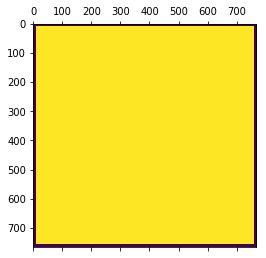

In [172]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# empty image
zp_dim = 10
out_img = np.ones((768-2*zp_dim, 768-2*zp_dim), dtype=bool)
out_img = np.pad(out_img, ((zp_dim, zp_dim),), mode='constant', constant_values=0)
plt.matshow(out_img)
print(out_img.shape)
pos_ship_str = rle_encode(out_img)
print(pos_ship_str[:50])

In [173]:
pos_ship_str

'7691 748 8459 748 9227 748 9995 748 10763 748 11531 748 12299 748 13067 748 13835 748 14603 748 15371 748 16139 748 16907 748 17675 748 18443 748 19211 748 19979 748 20747 748 21515 748 22283 748 23051 748 23819 748 24587 748 25355 748 26123 748 26891 748 27659 748 28427 748 29195 748 29963 748 30731 748 31499 748 32267 748 33035 748 33803 748 34571 748 35339 748 36107 748 36875 748 37643 748 38411 748 39179 748 39947 748 40715 748 41483 748 42251 748 43019 748 43787 748 44555 748 45323 748 46091 748 46859 748 47627 748 48395 748 49163 748 49931 748 50699 748 51467 748 52235 748 53003 748 53771 748 54539 748 55307 748 56075 748 56843 748 57611 748 58379 748 59147 748 59915 748 60683 748 61451 748 62219 748 62987 748 63755 748 64523 748 65291 748 66059 748 66827 748 67595 748 68363 748 69131 748 69899 748 70667 748 71435 748 72203 748 72971 748 73739 748 74507 748 75275 748 76043 748 76811 748 77579 748 78347 748 79115 748 79883 748 80651 748 81419 748 82187 748 82955 748 83723 748 844

In [174]:
#submission_df['EncodedPixels'] = submission_df['score'].map(lambda x: pos_ship_str if x>0.5 else None)

In [175]:
p=preds[1]
p

'7691 748 8459 748 9227 748 9995 748 10763 748 1153'

In [176]:
for i in range(len(preds)):
    if preds[i] == 0:
        preds[i] = None
    if preds[i] == '7691 748 8459 748 9227 748 9995 748 10763 748 1153':
        preds[i] = pos_ship_str

In [177]:
preds[:10]

[None,
 '7691 748 8459 748 9227 748 9995 748 10763 748 11531 748 12299 748 13067 748 13835 748 14603 748 15371 748 16139 748 16907 748 17675 748 18443 748 19211 748 19979 748 20747 748 21515 748 22283 748 23051 748 23819 748 24587 748 25355 748 26123 748 26891 748 27659 748 28427 748 29195 748 29963 748 30731 748 31499 748 32267 748 33035 748 33803 748 34571 748 35339 748 36107 748 36875 748 37643 748 38411 748 39179 748 39947 748 40715 748 41483 748 42251 748 43019 748 43787 748 44555 748 45323 748 46091 748 46859 748 47627 748 48395 748 49163 748 49931 748 50699 748 51467 748 52235 748 53003 748 53771 748 54539 748 55307 748 56075 748 56843 748 57611 748 58379 748 59147 748 59915 748 60683 748 61451 748 62219 748 62987 748 63755 748 64523 748 65291 748 66059 748 66827 748 67595 748 68363 748 69131 748 69899 748 70667 748 71435 748 72203 748 72971 748 73739 748 74507 748 75275 748 76043 748 76811 748 77579 748 78347 748 79115 748 79883 748 80651 748 81419 748 82187 748 82955 748 83723

In [178]:
d=test_v2[:5]
d

['1c1a63015.jpg',
 '05cf6c026.jpg',
 'bd8405c05.jpg',
 '29b46cda8.jpg',
 '4d045477e.jpg']

In [179]:
res = np.column_stack((test_v2, preds))

In [180]:
res[:5]

array([['1c1a63015.jpg', None],
       ['05cf6c026.jpg',
        '7691 748 8459 748 9227 748 9995 748 10763 748 11531 748 12299 748 13067 748 13835 748 14603 748 15371 748 16139 748 16907 748 17675 748 18443 748 19211 748 19979 748 20747 748 21515 748 22283 748 23051 748 23819 748 24587 748 25355 748 26123 748 26891 748 27659 748 28427 748 29195 748 29963 748 30731 748 31499 748 32267 748 33035 748 33803 748 34571 748 35339 748 36107 748 36875 748 37643 748 38411 748 39179 748 39947 748 40715 748 41483 748 42251 748 43019 748 43787 748 44555 748 45323 748 46091 748 46859 748 47627 748 48395 748 49163 748 49931 748 50699 748 51467 748 52235 748 53003 748 53771 748 54539 748 55307 748 56075 748 56843 748 57611 748 58379 748 59147 748 59915 748 60683 748 61451 748 62219 748 62987 748 63755 748 64523 748 65291 748 66059 748 66827 748 67595 748 68363 748 69131 748 69899 748 70667 748 71435 748 72203 748 72971 748 73739 748 74507 748 75275 748 76043 748 76811 748 77579 748 78347 748 79115 74

In [181]:
print(len(res))
print(type(res))

15606
<class 'numpy.ndarray'>


In [182]:
import pandas as pd
df = pd.DataFrame(res)
#df.to_csv('submission_1000pic_20bat_2ep.csv')

In [183]:
df.columns = ['ImageId', 'EncodedPixels']

In [184]:
df.head()

,ImageId,EncodedPixels
0,1c1a63015.jpg,None
1,05cf6c026.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
2,bd8405c05.jpg,None
3,29b46cda8.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
4,4d045477e.jpg,None


In [185]:
df = df.sort_values(['ImageId'])

In [186]:
df.head()

,ImageId,EncodedPixels
13929,00002bd58.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
5742,00015efb6.jpg,None
8837,00023d5fc.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
12983,000367c13.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
1930,0008ca6e9.jpg,None


In [187]:
df.shape

(15606, 2)

In [188]:
df.drop_duplicates(subset='ImageId',keep=False,inplace=True)

In [189]:
df.head()

,ImageId,EncodedPixels
13929,00002bd58.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
5742,00015efb6.jpg,None
8837,00023d5fc.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
12983,000367c13.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
1930,0008ca6e9.jpg,None


In [190]:
df.shape

(15606, 2)

In [191]:
df.to_csv("submission_1000pic_20bat_2ep.csv", index=False)

In [192]:
abc=pd.DataFrame([[4,5,6],[7,8,9],[1,2,3]])
abc.columns = ['a','b','c']
abc

,a,b,c
0,4,5,6
1,7,8,9
2,1,2,3


In [193]:
abc=abc.sort_values(['a'])
abc

,a,b,c
2,1,2,3
0,4,5,6
1,7,8,9


In [194]:
#takes too much time
#numpy.savetxt("submissions_1000p_20b_2ep.csv", res, delimiter=",")

In [195]:
"""
# we call the predict method on our estimator
# this method will not return the entire prediction dataset at once but it returns a python generator 
# which we can use to iterate through the predictions one by one
# first we initialize our generator
generator = cnn_classifier.predict(input_fn=predict_input_fn)

# then we store all predictions into a list of dictionaries
# (dictionary from classes and probabilities which we defined in the model function)
predictions = [next(generator) for i in range(len(test_data))]

# Kaggle are interested only in the classes predictions without the probabilities
# thus we get only the classes in a new list
classes = [predictions[i]['classes'] for i in range(len(predictions))]

# finally we write our predictions into a csv file
def generate_submission_file(predictions, fileName):
    submission = pd.DataFrame()
    
    submission['ImageId'] = range(1,15606,1)
    submission['EncodedPixels'] = predictions
    submission.set_index('ImageId', inplace=True)
    submission.to_csv(fileName)
    
    print('Submission Ready!')
    
generate_submission_file(classes, 'submission_1000pic_20bat_2ep.csv')
"""

"\n# we call the predict method on our estimator\n# this method will not return the entire prediction dataset at once but it returns a python generator \n# which we can use to iterate through the predictions one by one\n# first we initialize our generator\ngenerator = cnn_classifier.predict(input_fn=predict_input_fn)\n\n# then we store all predictions into a list of dictionaries\n# (dictionary from classes and probabilities which we defined in the model function)\npredictions = [next(generator) for i in range(len(test_data))]\n\n# Kaggle are interested only in the classes predictions without the probabilities\n# thus we get only the classes in a new list\nclasses = [predictions[i]['classes'] for i in range(len(predictions))]\n\n# finally we write our predictions into a csv file\ndef generate_submission_file(predictions, fileName):\n    submission = pd.DataFrame()\n    \n    submission['ImageId'] = range(1,15606,1)\n    submission['EncodedPixels'] = predictions\n    submission.set_index